I have used a tool called ogr2ogr to convert the original json

with uses coordinates with WGS84(EPSG:4326) to projection (EPSG:31983)

Commands: ogr2ogr -f "GeoJSON" -t_srs "EPSG:31983" sergipeEPSG31983.geojson sergipe.json

Github of the original JSON: https://github.com/giuliano-macedo/geodata-br-states

EPSG:4326: https://epsg.io/4326

EPSG:31983: https://epsg.io/31983


Import the necessary library's


In [66]:
from itertools import chain
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from integrationsMethods import (
    result_I_Simpson_with_y_list,
    result_I_trapezoid_with_y_list,
)
import numpy as np
from shapely import Polygon

Configuration


In [67]:
class Options:
    _offset_x = 1.34e6  # Remove the tuple wrapping
    _offset_y = 8.82e6  # Remove the tuple wrapping
    _state_name = "sergipe"
    _file_name = "sergipeEPSG31983"
    _feature_index = 0
    _geometry_path = [0, 0]
    _weight = 1e4
    _start_x = -10  # Remove the tuple wrapping
    _end_x = 10.5  # Remove the tuple wrapping
    _step_x = 0.5  # Remove the tuple wrapping
    _figsize = (10, 8)  # Keep as tuple (correct usage)
    _linewidth = 2  # Remove the tuple wrapping
    _line_color = "#2E86AB"  # Remove the tuple wrapping
    _point_color = "red"  # Remove the tuple wrapping
    _point_size = 20  # Remove the tuple wrapping
    _major_tick_spacing = 1  # Remove the tuple wrapping
    _minor_tick_spacing = 0.5  # Remove the tuple wrapping
    _show_intersection_points = True
    _area_oficial_km2 = 21910  # Área oficial do Estado

    def set_offset(self, offset_x, offset_y, weight):
        self._offset_x = offset_x
        self._offset_y = offset_y
        self._weight = weight

    def get(self):
        return (
            self._state_name,
            self._file_name,
            self._feature_index,
            self._geometry_path,
            self._offset_x,
            self._offset_y,
            self._weight,
            self._start_x,
            self._end_x,
            self._step_x,
            self._figsize,
            self._linewidth,
            self._line_color,
            self._point_color,
            self._point_size,
            self._major_tick_spacing,
            self._minor_tick_spacing,
            self._show_intersection_points,
            self._area_oficial_km2,
        )


if __name__ == "__main__":
    options = Options()

    # Amazonas
    # options.set_offset(offset_x=-1.75e6, offset_y=0.95e7, weight=1e5)

    (
        state_name,
        file_name,
        feature_index,
        geometry_path,
        offset_x,
        offset_y,
        weight,
        start_x,
        end_x,
        step_x,
        figsize,
        linewidth,
        line_color,
        point_color,
        point_size,
        major_tick_spacing,
        minor_tick_spacing,
        show_intersection_points,
        area_oficial_km2,
    ) = options.get()

Extract the points from the geojson


In [68]:
def load_geojson_coordinates() -> list[list[float, float]]:
    """
    Load coordinates from a GeoJSON file.

    Parameters:
    -----------
    file_name : str, optional
        Name of the GeoJSON file without extension (default: 'sergipeEPSG31983')
    feature_index : int, optional
        Index of the feature to extract (default: 0)
    geometry_path : list, optional
        Path to navigate through nested coordinate arrays (default: [0, 0])

    Returns:
    --------
    list
        List of coordinate points in format [(x1, y1), (x2, y2), ...]
    """
    with open(f"./{file_name}.geojson") as f:
        data = json.load(f)

    coordinates = data["features"][feature_index]["geometry"]["coordinates"]

    # Navigate through nested coordinate structure
    for index in geometry_path:
        coordinates = coordinates[index]

    return coordinates


# Usage example:
if __name__ == "__main__":
    points = load_geojson_coordinates()
    print(points[1:10])

[[1445043.5942277391, 8825841.000941774], [1444354.6955312681, 8824995.779494215], [1444321.8981292855, 8824085.916412512], [1443633.0905528301, 8824354.142998593], [1440374.1078805318, 8824054.382871382], [1433459.7139616904, 8822311.558879286], [1421992.3467790252, 8817978.15827443], [1419736.9343763096, 8816986.072678983], [1413738.5923875105, 8812752.87793497]]


Generate the coordinates of the State perimeter


In [69]:
def normalize_coordinates(
    points,
):
    """
    Normalize geographic coordinates by applying offset and weight transformations.

    Parameters:
    -----------
    points : list of tuples
        List of coordinate points in format [(x1, y1), (x2, y2), ...]
    offset_x : float, optional
        X-axis offset to subtract (default: 1.34e6)
    offset_y : float, optional
        Y-axis offset to subtract (default: 8.82e6)
    weight : float, optional
        Scaling factor to divide by (default: 1e4)

    Returns:
    --------
    tuple
        (x, y) - Two lists containing normalized X and Y coordinates
    """
    x = [(point[0] - offset_x) / weight for point in points]
    y = [(point[1] - offset_y) / weight for point in points]

    return x, y


# Usage example:
if __name__ == "__main__":
    x, y = normalize_coordinates(points)
    print(x[1:10])
    print(y[1:10])

[10.504359422773915, 10.435469553126813, 10.432189812928554, 10.363309055283013, 10.037410788053181, 9.345971396169043, 8.199234677902515, 7.9736934376309625, 7.373859238751046]
[0.5841000941773876, 0.4995779494214803, 0.408591641251184, 0.4354142998592928, 0.40543828713819385, 0.23115588792860509, -0.20218417255692184, -0.30139273210167883, -0.7247122065030038]


Intersections Points


In [ ]:
def find_all_y_for_x(x_target, x_points, y_points):
    """
    Find all Y values where a vertical line at x_target intersects
    the polygon perimeter defined by x_points and y_points.

    Returns a list of Y values (can be multiple for a closed polygon).
    """
    y_intersections = []

    # Iterate through each line segment
    for i in range(len(x_points) - 1):
        x1, y1 = x_points[i], y_points[i]
        x2, y2 = x_points[i + 1], y_points[i + 1]

        # Check if the vertical line at x_target intersects this segment
        # The segment must span across x_target
        if (x1 <= x_target <= x2) or (x2 <= x_target <= x1):
            # Avoid division by zero for vertical segments
            if x2 - x1 == 0:
                if x1 == x_target:
                    y_intersections.append(y1)
                    y_intersections.append(y2)
            else:
                # Linear interpolation: y = y1 + (y2-y1)/(x2-x1) * (x_target-x1)
                t = (x_target - x1) / (x2 - x1)
                y_intersection = y1 + t * (y2 - y1)
                y_intersections.append(y_intersection)

    # Remove duplicates and sort
    y_intersections = reversed(sorted(list(set(y_intersections))))

    points = [(x_target, y) for y in y_intersections]

    return points


def generate_intersection_points(
    x_points,
    y_points,
):
    """
    Generate intersection points between vertical lines and a polygon perimeter.

    Parameters:
    -----------
    x_points : list
        X coordinates of the polygon perimeter
    y_points : list
        Y coordinates of the polygon perimeter
    start_x : float, optional
        Starting X value for the interval (default: -10)
    end_x : float, optional
        Ending X value for the interval (default: 10.5)
    step_x : float, optional
        Step size between vertical lines (default: 0.5)
    weight : int, optional
        Multiplier for precision in range calculations (default: 1000)

    Returns:
    --------
    tuple
        (x_interval, y_interval, points_interval, all_y_in_x)
        - x_interval: list of X coordinates of intersection points
        - y_interval: list of Y coordinates of intersection points
        - points_interval: list of (x, y) tuples
        - all_y_in_x: list of intersection points grouped by X value
    """
    start = int(start_x * weight)
    end = int(end_x * weight)
    step = int(step_x * weight)

    x_range = list(range(start, end, step))
    all_y_in_x = [
        find_all_y_for_x(x_target / weight, x_points, y_points) for x_target in x_range
    ]

    points_interval = list(chain(*all_y_in_x))
    x_interval = [point[0] for point in points_interval]
    y_interval = [point[1] for point in points_interval]

    return x_interval, y_interval, points_interval, all_y_in_x


if __name__ == "__main__":
    
    x_interval, y_interval, points_interval, all_y_in_x = generate_intersection_points(
        x,
        y,
    )
    print(x_interval[1:10])
    print(y_interval[1:10])
    print(points_interval[1:10])
    print(all_y_in_x[1:10])

[-10.0, -10.0, -9.5, -9.5, -9.0, -9.0, -8.5, -8.5, -8.5, -8.5, -8.0, -8.0, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -6.5, -6.5, -6.5, -6.5, -6.0, -6.0, -6.0, -6.0, -6.0, -6.0, -5.5, -5.5, -5.5, -5.5, -5.5, -5.5, -5.5, -5.5, -5.0, -5.0, -5.0, -5.0, -4.5, -4.5, -4.5, -4.5, -4.0, -4.0, -3.5, -3.5, -3.0, -3.0, -2.5, -2.5, -2.0, -2.0, -1.5, -1.5, -1.0, -1.0, -0.5, -0.5, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 2.5, 2.5, 3.0, 3.0, 3.5, 3.5, 4.0, 4.0, 4.5, 4.5, 5.0, 5.0, 5.5, 5.5, 6.0, 6.0, 6.5, 6.5, 7.0, 7.0, 7.5, 7.5, 8.0, 8.0, 8.5, 8.5, 9.0, 9.0, 9.5, 9.5, 10.0, 10.0]
[-2.4603402274737807, -2.4689512209752857, -1.2440164711004065, -3.7731094438025097, -1.2566891202512762, -4.46948952729394, -1.2739867202281712, -4.625637606967094, -4.732430238260725, -4.795506163921905, -1.3005569624230697, -6.430962999106667, 10.002329338893379, 9.759600214016894, -1.5031716843360488, -6.593235995314719, -7.678352219280852, -7.758884078381855, 12.0160753

Calculate the area


In [71]:
def calculate_total_distance(item: list[tuple[float, float]]) -> float:
    """
    Calculate the total vertical distance between pairs of points.

    This function takes a list of coordinate points and calculates the sum of
    vertical distances (y-coordinate differences) between consecutive pairs.
    Points are paired as (0,1), (2,3), (4,5), etc.

    Parameters:
    -----------
    item : list[tuple[float, float]]
        List of coordinate points in format [(x1, y1), (x2, y2), ...].
        The list should have an even number of elements for proper pairing.

    Returns:
    --------
    float
        The sum of absolute vertical distances between all pairs of points.
        Returns 0 if the list is empty or has fewer than 2 elements.

    Examples:
    ---------
    >>> calculate_total_distance([(0, 0), (0, 5), (1, 10), (1, 3)])
    12.0  # |0-5| + |10-3| = 5 + 7 = 12

    >>> calculate_total_distance([])
    0

    Notes:
    ------
    - Uses numpy for vectorized operations, improving performance over loops
    - Only processes complete pairs; ignores any unpaired final point
    - The x-coordinates are not used in the calculation
    """
    if not len(item):
        return 0

    # Convert to numpy array for vectorized operations
    points = np.array(item)

    # Extract y-coordinates for all points
    y_coords = points[:, 1]

    # Calculate number of complete pairs
    n_pairs = len(y_coords) // 2
    if n_pairs > 0:
        # Reshape to pair consecutive points: [[y0, y1], [y2, y3], ...]
        y_pairs = y_coords[: n_pairs * 2].reshape(n_pairs, 2)
        # Calculate absolute differences for all pairs at once
        distances = np.abs(y_pairs[:, 0] - y_pairs[:, 1])
        # Sum all distances
        return np.sum(distances)

    return 0


def area():
    total_distances = list(map(calculate_total_distance, all_y_in_x))
    area_m2_trapezoid = result_I_trapezoid_with_y_list(total_distances, step_x) * (
        weight**2
    )
    area_m2_Simpson = result_I_Simpson_with_y_list(total_distances, step_x) * (
        weight**2
    )
    area_km2_trapezoid = area_m2_trapezoid / 1e6
    area_km2_Simpson = area_m2_Simpson / 1e6

    # Calculate Shapely area
    polygon = Polygon(points)
    area_m2_shapely = polygon.area
    area_km2_shapely = area_m2_shapely / 1e6

    return (
        area_m2_trapezoid,
        area_m2_Simpson,
        area_km2_trapezoid,
        area_km2_Simpson,
        area_m2_shapely,
        area_km2_shapely,
    )


if __name__ == "__main__":
    (
        area_m2_trapezoid,
        area_m2_Simpson,
        area_km2_trapezoid,
        area_km2_Simpson,
        area_m2_shapely,
        area_km2_shapely,
    ) = area()
    print(area_m2_trapezoid)
    print(area_m2_Simpson)
    print(area_km2_trapezoid)
    print(area_km2_Simpson)
    print(area_m2_shapely)
    print(area_km2_shapely)

11095503227.493845
22101759014.37025
11095.503227493846
22101.75901437025
22264981978.365738
22264.981978365737


Area Result


In [72]:
def result(
    area_m2_trapezoid,
    area_m2_Simpson,
    area_km2_trapezoid,
    area_km2_Simpson,
    area_m2_shapely,
    area_km2_shapely,
):
    if not area_m2_trapezoid or not area_m2_Simpson or not area_km2_trapezoid or not area_km2_Simpson:
        print("There is no result!")
        return

    print("=" * 60)
    print(f"CÁLCULO DA ÁREA DO ESTADO: {state_name.upper()}")
    print("=" * 60)

    print(f"\nÁrea Oficial (IBGE):")
    print(f"  Área em km²: {area_oficial_km2:,.2f} km²")

    print(f"\nMétodo do Trapézio:")
    print(f"  Área em m²:  {area_m2_trapezoid:,.2f} m²")
    print(f"  Área em km²: {area_km2_trapezoid:,.2f} km²")
    erro_trapezoid = abs(area_km2_trapezoid - area_oficial_km2)
    erro_relativo_trapezoid = (erro_trapezoid / area_oficial_km2) * 100
    print(f"  Erro absoluto: {erro_trapezoid:,.2f} km²")
    print(f"  Erro relativo:  {erro_relativo_trapezoid:.2f}%")

    print(f"\nMétodo de Simpson:")
    print(f"  Área em m²:  {area_m2_Simpson:,.2f} m²")
    print(f"  Área em km²: {area_km2_Simpson:,.2f} km²")
    erro_simpson = abs(area_km2_Simpson - area_oficial_km2)
    erro_relativo_simpson = (erro_simpson / area_oficial_km2) * 100
    print(f"  Erro absoluto: {erro_simpson:,.2f} km²")
    print(f"  Erro relativo:  {erro_relativo_simpson:.2f}%")

    print(f"\nMétodo Shapely (Referência):")
    print(f"  Área em m²:  {area_m2_shapely:,.2f} m²")
    print(f"  Área em km²: {area_km2_shapely:,.2f} km²")
    erro_shapely = abs(area_km2_shapely - area_oficial_km2)
    erro_relativo_shapely = (erro_shapely / area_oficial_km2) * 100
    print(f"  Erro absoluto: {erro_shapely:,.2f} km²")
    print(f"  Erro relativo:  {erro_relativo_shapely:.2f}%")

    print(f"\nDiferença entre Trapézio e Simpson:")
    print(
        f"  Diferença absoluta: {abs(area_km2_trapezoid - area_km2_Simpson):,.2f} km²"
    )
    print(
        f"  Diferença relativa:  {abs(area_km2_trapezoid - area_km2_Simpson) / area_km2_trapezoid * 100:.2f}%"
    )

    print(f"\nDiferença entre Trapézio e Shapely:")
    print(
        f"  Diferença absoluta: {abs(area_km2_trapezoid - area_km2_shapely):,.2f} km²"
    )
    print(
        f"  Diferença relativa:  {abs(area_km2_trapezoid - area_km2_shapely) / area_km2_shapely * 100:.2f}%"
    )

    print(f"\nDiferença entre Simpson e Shapely:")
    print(f"  Diferença absoluta: {abs(area_km2_Simpson - area_km2_shapely):,.2f} km²")
    print(
        f"  Diferença relativa:  {abs(area_km2_Simpson - area_km2_shapely) / area_km2_shapely * 100:.2f}%"
    )

    print("=" * 60)


if __name__ == "__main__":
    try:
        result(
            area_m2_trapezoid,
            area_m2_Simpson,
            area_km2_trapezoid,
            area_km2_Simpson,
            area_m2_shapely,
            area_km2_shapely,
        )
    except:
        raise ValueError

CÁLCULO DA ÁREA DO ESTADO: SERGIPE

Área Oficial (IBGE):
  Área em km²: 21,910.00 km²

Método do Trapézio:
  Área em m²:  11,095,503,227.49 m²
  Área em km²: 11,095.50 km²
  Erro absoluto: 10,814.50 km²
  Erro relativo:  49.36%

Método de Simpson:
  Área em m²:  22,101,759,014.37 m²
  Área em km²: 22,101.76 km²
  Erro absoluto: 191.76 km²
  Erro relativo:  0.88%

Método Shapely (Referência):
  Área em m²:  22,264,981,978.37 m²
  Área em km²: 22,264.98 km²
  Erro absoluto: 354.98 km²
  Erro relativo:  1.62%

Diferença entre Trapézio e Simpson:
  Diferença absoluta: 11,006.26 km²
  Diferença relativa:  99.20%

Diferença entre Trapézio e Shapely:
  Diferença absoluta: 11,169.48 km²
  Diferença relativa:  50.17%

Diferença entre Simpson e Shapely:
  Diferença absoluta: 163.22 km²
  Diferença relativa:  0.73%


Graph Configuration


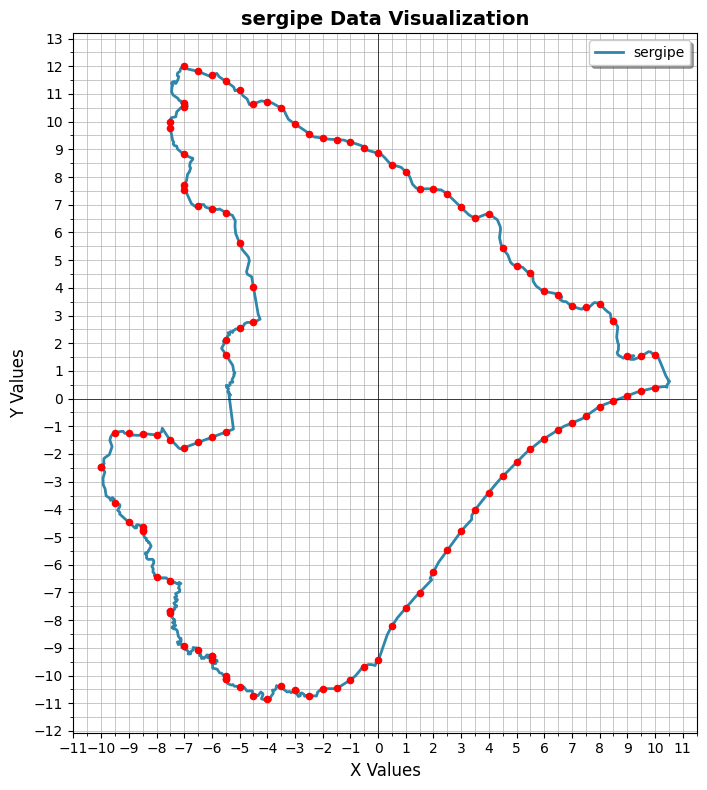

In [73]:
def plot_state_visualization(x, y, x_interval=(None,), y_interval=(None,)):
    """
    Create a visualization plot for a Brazilian State geographic data with optional intersection points.

    Parameters:
    -----------
    x : list or array-like
        X coordinates of the State perimeter
    y : list or array-like
        Y coordinates of the State perimeter
    x_interval : list or array-like, optional
        X coordinates of intersection points (default: None)
    y_interval : list or array-like, optional
        Y coordinates of intersection points (default: None)
    figsize : tuple, optional
        Figure size as (width, height) in inches (default: (10, 8))
    linewidth : float, optional
        Width of the perimeter line (default: 2)
    line_color : str, optional
        Color of the perimeter line (default: "#2E86AB")
    point_color : str, optional
        Color of intersection points (default: "red")
    point_size : float, optional
        Size of intersection point markers (default: 20)
    major_tick_spacing : float, optional
        Spacing between major grid lines (default: 1)
    minor_tick_spacing : float, optional
        Spacing between minor grid lines (default: 0.5)
    show_intersection_points : bool, optional
        Whether to display intersection points (default: True)

    Returns:
    --------
    tuple
        (fig, ax) - The matplotlib figure and axis objects

    Examples:
    ---------
    >>> fig, ax = plot_state_visualization(x, y)
    >>> fig, ax = plot_state_visualization(x, y, x_interval, y_interval)
    >>> fig, ax = plot_state_visualization(x, y, line_color="blue", point_size=30)

    Notes:
    ------
    - The plot includes both major and minor grid lines for better readability
    - Aspect ratio is set to 1:1 for accurate geographic representation
    - Axes are centered at (0,0) with visible horizontal and vertical lines
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Plot main perimeter line
    ax.plot(x, y, linewidth=linewidth, label=state_name, color=line_color)

    # Set up the grid with major and minor divisions
    ax.grid(True, which="both", linestyle="-", linewidth=0.7, alpha=0.7)

    # Add axes at (0,0)
    ax.axhline(y=0, color="k", linewidth=0.5)
    ax.axvline(x=0, color="k", linewidth=0.5)
    # Configure tick spacing
    ax.minorticks_on()
    ax.xaxis.set_major_locator(MultipleLocator(major_tick_spacing))
    ax.yaxis.set_major_locator(MultipleLocator(major_tick_spacing))
    ax.xaxis.set_minor_locator(MultipleLocator(minor_tick_spacing))
    ax.yaxis.set_minor_locator(MultipleLocator(minor_tick_spacing))
        
    # Set equal aspect ratio for geographic accuracy
    ax.set_aspect(1)

    # Add labels and title
    ax.set_xlabel("X Values", fontsize=12)
    ax.set_ylabel("Y Values", fontsize=12)
    ax.set_title(f"{state_name} Data Visualization", fontsize=14, fontweight="bold")

    # Add legend
    ax.legend(loc="best", frameon=True, fancybox=True, shadow=True)

    # Improve tick formatting
    ax.tick_params(axis="both", which="major", labelsize=10)

    # Add intersection points if provided and enabled
    if show_intersection_points and x_interval is not None and y_interval is not None:
        ax.scatter(
            x_interval,
            y_interval,
            s=point_size,
            color=point_color,
            label="Intersection Points",
            zorder=5,
        )

    # Adjust layout to prevent clipping
    plt.tight_layout()

    return fig, ax


# Usage example:
if __name__ == "__main__":
    fig, ax = plot_state_visualization(
        x, y, x_interval=x_interval, y_interval=y_interval
    )
    plt.show()